# Аналитика в Яндекс.Афише<a class="tocSkip">

## Описанние проекта<a class="tocSkip">

**В данном проекте нам предстоит определить возможные варианты оптимизации маркетинговых затрат. В нашем распоряжении данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года: лог сервера с данными о посещениях сайта Яндекс.Афиши, выгрузка всех заказов за этот период и статистика рекламных расходов. Нам предстоит выяснить: как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент и когда клиент окупается.**

## Оглавление<a class="tocSkip">

[1.Открытие данных](#start)

[2 Предобработка данных](#preprocessing)

- [Переименование столбцов](#renaming)

- [Изменение типов данных](#changing)

- [Поиск дубликатов](#duplicates)

[3.Продукт](#product)

- [Количество людей пользующихся сервисом в день, неделю, месяц](#product1)

- [Число сессий в день](#product2)

- [Продолжительность одной сессии - ASL](#product3)

- [Как часто люди возвращаются - Retention Rat](#product4)

[4.Продажи](#sales)

- [Время до совершения первой покупки](#sales1)

- [Количество покупок за период](#sales2)

- [Средний чек](#sales3)

- [«Пожизненная» ценность клиента - LTV](#sales4)

[5.Маркетинг](#marketing)

- [Расходы на маркетинг: общие / на каждый источник / по времени](#marketing)

- [Стоимость  привлечения одного покупателя из каждого источника CAC](#marketing2)

- [Окупаемость расходов - ROI](#marketing3)

[6.Общий вывод](#close)

<a id="start"></a>
## 1 Открытие данных<a class="tocSkip">

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')

In [3]:
orders = pd.read_csv('/datasets/orders_log.csv')

In [4]:
costs = pd.read_csv('/datasets/costs.csv')

In [5]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [6]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [7]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Данные получены, переходим к их оптимизации.

<a id="preprocessing"></a>
## 2 Предобработка данных<a class="tocSkip">

<a id="renaming"></a>
- __Переименование столбцов__

В таблицах "visits" и "orders" в названиях столбцов заменим прописные буквы на строчные, а пробелы на "_".

In [8]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

In [9]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

In [10]:
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [11]:
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

<a id="changing"></a>
- __Изменение типов данных__

In [12]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Во всех таблицах некорректно указанн формат дат, - приведем к "datetime".

In [15]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')

In [16]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')

In [17]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')

In [18]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d %H:%M:%S')

In [19]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [20]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [21]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


<a id="duplicates"></a>
- __Поиск дубликатов__

In [22]:
visits.duplicated().sum()

0

In [23]:
orders.duplicated().sum()

0

In [24]:
costs.duplicated().sum()

0

Названия столбцов перименованны, тип данных в колонках с датой приведен к "datetime", пропусков и дубликатов не обнаружено. Переходим к анализу данных.

<a id="product"></a>
## 3 Продукт<a class="tocSkip">

<a id="product1"></a>
- __Количество людей пользующихся сервисом в день, неделю, месяц__

In [25]:
visits['start_ts_date'] = visits['start_ts'].dt.date

In [26]:
visits['start_ts_week']  = visits['start_ts'].dt.week

In [27]:
visits['start_ts_month'] = visits['start_ts'].dt.month

In [28]:
visits['start_ts_year'] = visits['start_ts'].dt.year

In [29]:
dau_total = visits.groupby('start_ts_date').agg({'uid': 'nunique'}).mean()

In [30]:
wau_total = visits.groupby(['start_ts_year', 'start_ts_week']).agg({'uid': 'nunique'}).mean()

In [31]:
mau_total = visits.groupby(['start_ts_year', 'start_ts_month']).agg({'uid': 'nunique'}).mean()

In [32]:
print('Среднее количество пользователей в день:', int(dau_total))

Среднее количество пользователей в день: 907


In [33]:
print('Среднее количество пользователей в неделю:', int(wau_total))

Среднее количество пользователей в неделю: 5716


In [34]:
print('Среднее количество пользователей в месяц:', int(mau_total))

Среднее количество пользователей в месяц: 23228


<a id="product2"></a>
- __Число сессий в день__

In [35]:
session_per_day_mean = visits.groupby('start_ts_date').agg({'uid': 'count'}).mean()

In [36]:
print('Ежедневное среднее количество сессий:', int(session_per_day_mean))

Ежедневное среднее количество сессий: 987


<a id="product3"></a>
- __Продолжительность одной сессии - ASL__

In [37]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [38]:
print('ASL, мин:', int(visits['session_duration_sec'].mean() / 60))

ASL, мин: 10


Построим гистограмму, чтобы оценить распределение

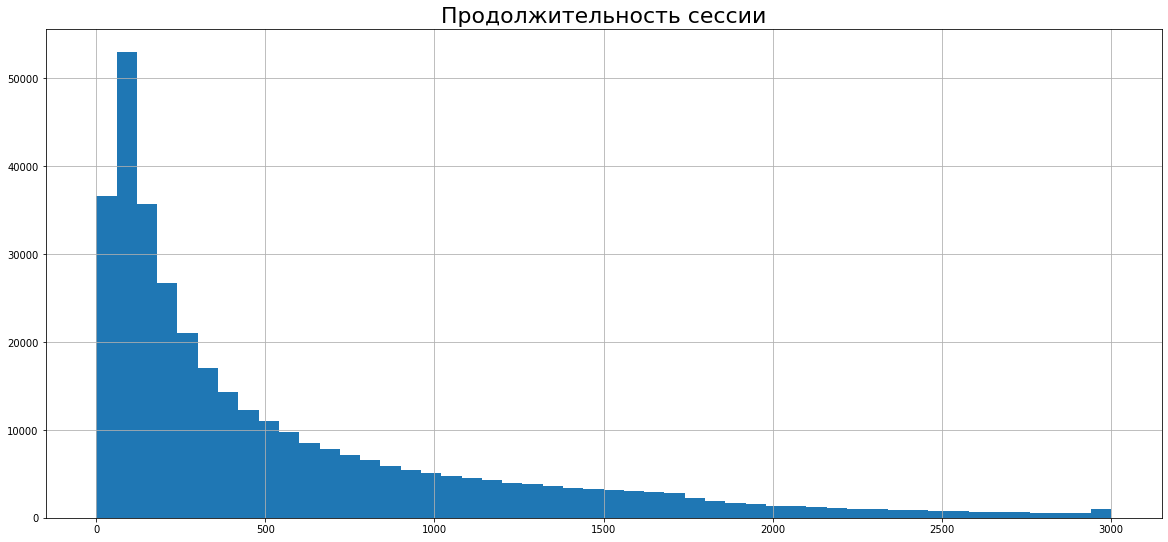

In [39]:
visits['session_duration_sec'].hist(bins=50, range=(0, 3000), figsize=(20, 9))
plt.title('Продолжительность сессии', fontsize=22)
plt.show()

Распределение далеко от нормального, следовательно вместо среднего возьмем моду - наиболее часто встречающееся значение.

In [40]:
print('Мода, сек:', int(visits['session_duration_sec'].mode()))

Мода, сек: 60


Модальное время сессии всего лишь 1 минута, - вероятно этого недостаточно для совершения покупки. возможно проблема в быстродействии сайта, удобства работы с ним или разнообразии способов оплаты.

<a id="product4"></a>
- __Как часто люди возвращаются - Retention Rat__

Retention Rat - коэффициент удержания. Для его рассчета определим событие и период — на их основе сформируем когорту.

In [41]:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()

In [42]:
first_activity_date.name = 'first_activity_date'

In [43]:
visits = visits.join(first_activity_date,on='uid')

In [44]:
visits['activity_month'] = visits['start_ts_date'].astype('datetime64[M]')

In [45]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

In [46]:
visits.head(1)

,device,end_ts,source_id,start_ts,uid,start_ts_date,start_ts_week,start_ts_month,start_ts_year,session_duration_sec,first_activity_date,activity_month,first_activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01


In [47]:
visits['cohort_lifetime'] = ((visits['activity_month'] - visits['first_activity_month'])\
/ np.timedelta64(1, 'M')).round().astype('int')

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей.

In [48]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime'])\
.agg({'uid':'nunique'}).reset_index()

In [49]:
cohorts.tail()

,first_activity_month,cohort_lifetime,uid
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760
77,2018-05-01,0,15273


In [50]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count

,first_activity_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [51]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [52]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

In [53]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

In [54]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',\
                                      columns='cohort_lifetime',values='retention',aggfunc='sum') 

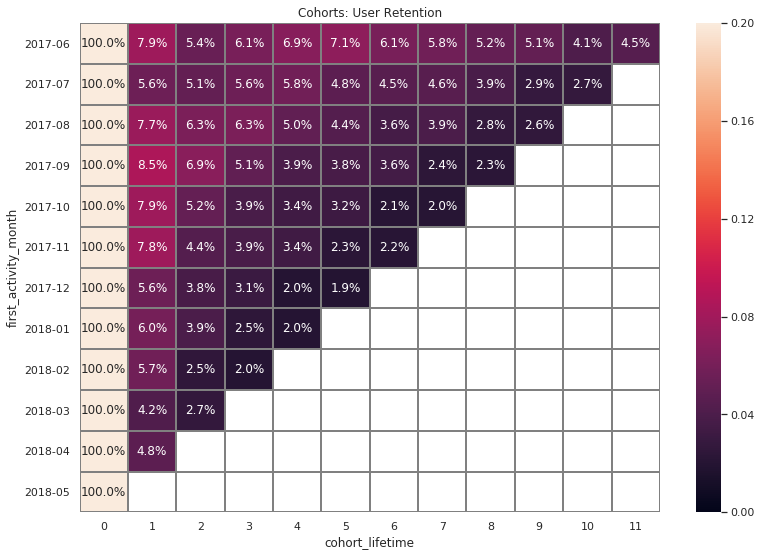

In [55]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',\
            yticklabels=retention_pivot.index.strftime('%Y-%m'), vmin = 0, vmax= 0.2); 


Судя по тепловой карте мы можем сказать, что и ипользователи из первых когорт редко возвращались в сервис, - уже в первом месяце коэффициент удержания был 8,5% - 7,9% и со временем только падал. Но в последних когортах даже в первый месяц возвращалось менее 5% пользователей. Т.е. и без того невысокая удовлетворенность клиентов упала еще ниже.

<a id="sales"></a>
## 4 Продажи<a class="tocSkip">

<a id="sales1"></a>
- __Время до совершения первой покупки__

Для рассчета нам потребуются время первого действия пользователя (оно уже расчитано - "first_activity_date") и время первой покупки, найдем его. Затем объеденим датасеты и рассчитаем искомую величину.

In [56]:
first_orders = orders.groupby(['uid']).agg({'buy_ts':'min'})

In [57]:
first_orders.columns = ['first_buy_ts']

In [58]:
first_orders = first_orders.join(first_activity_date,on='uid')

In [59]:
first_orders['time_to_first_purchase'] = (first_orders['first_buy_ts'] - first_orders['first_activity_date'])\
/ np.timedelta64(1, 'm')

In [60]:
first_orders['time_to_first_purchase'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: time_to_first_purchase, dtype: float64

Мы получили среднее значение 24340 мин. - почти 17 дней, медиану - 16 мин. Посмотрим на распределение.

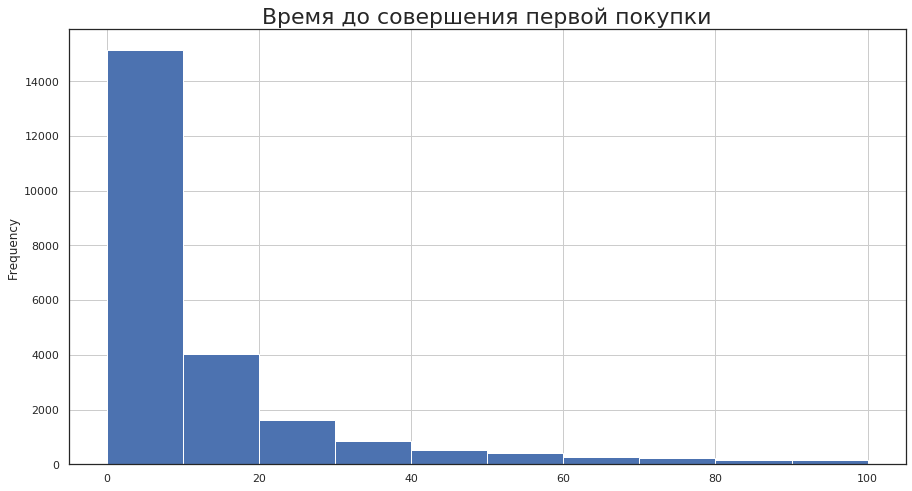

In [61]:
first_orders['time_to_first_purchase'].plot(kind = 'hist', range = (0,100), figsize = (15,8))
plt.title('Время до совершения первой покупки', fontsize=22)
plt.grid(True)
plt.show()

Гистограмма показывает, что распределение не является нормальным,- корректно ипользовать моду.

In [62]:
first_orders['time_to_first_purchase'].mode()

0    1.0
dtype: float64

Чаще всего пользователь покупает спустя минуту после первого посещения сервиса.

<a id="sales2"></a>
- __Количество покупок за период__

В качестве расчетного периода принимаем месяц.

In [63]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]').dt.strftime('%Y-%m')

In [64]:
orders.groupby('order_month')['buy_ts'].count().reset_index()

,order_month,buy_ts
0,2017-06,2354
1,2017-07,2363
2,2017-08,1807
3,2017-09,3387
4,2017-10,5679
5,2017-11,5659
6,2017-12,6218
7,2018-01,4721
8,2018-02,5281
9,2018-03,5326


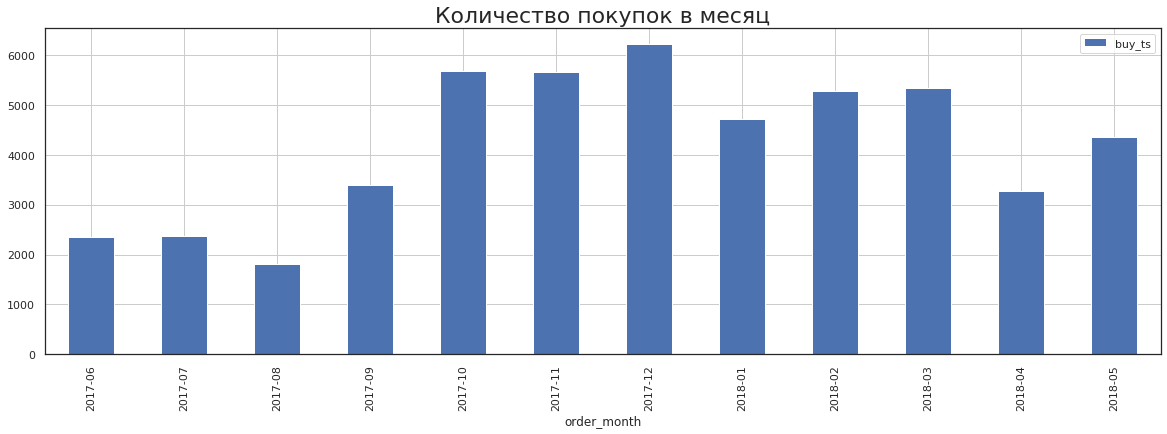

In [65]:
orders.query('order_month != "2018-06"').groupby('order_month')['buy_ts'].count()\
.reset_index().plot(kind='bar',figsize=(20, 6), x='order_month')
plt.title('Количество покупок в месяц', fontsize=22)
plt.grid(True)
plt.show()

In [66]:
orders.query('order_month != "2018-06"').groupby('order_month')['buy_ts'].count().reset_index().mean().round()

buy_ts    4201.0
dtype: float64

На графике мы видидим, что наименьшее количество покупок в летние месяцы, - сезон отпусков, затем с сентября начинается рост. Самые высокие значения - в декабре, вероятно преобретаются билеты на мероприятия в новогодние каникулы. В январе ожидаемый спад после предновогодних трат, после подъем в феврале и марте, и снова падение продаж, - вероятно расходы снова перенаправляются на летний отдых. Среднее количество покупок за год 4201.

<a id="sales3"></a>
- __Средний чек__

Расчитаем средний чек для периода в месяц.

In [67]:
orders.query('order_month != "2018-06"').groupby('order_month').agg({'revenue':'mean'})

,revenue
order_month,
2017-06,4.060106
2017-07,5.306589
2017-08,4.847139
2017-09,5.416448
2017-10,4.928280
2017-11,4.783518
2017-12,5.852139
2018-01,4.112927
2018-02,4.840095


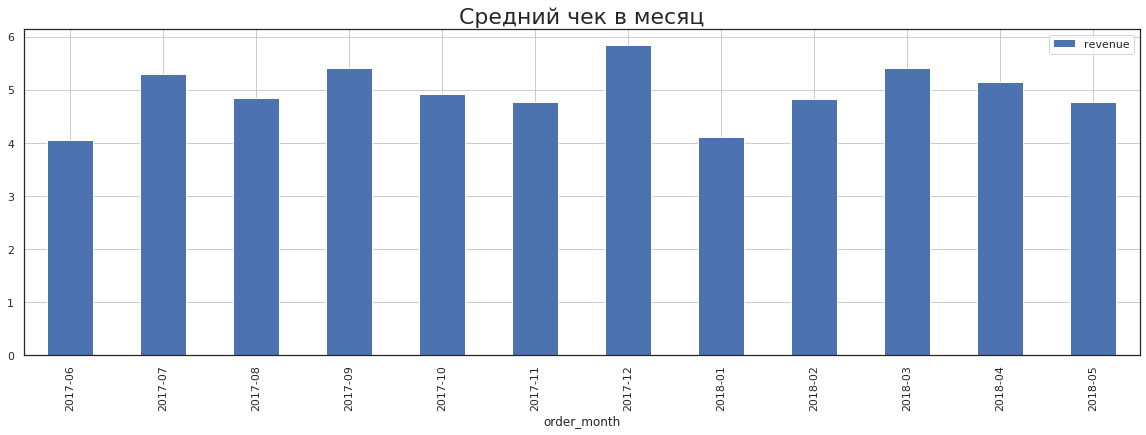

In [68]:
orders.query('order_month != "2018-06"').groupby('order_month').agg({'revenue':'mean'})\
.plot(kind='bar',figsize=(20, 6))
plt.title('Средний чек в месяц', fontsize=22)
plt.grid(True)
plt.show()

In [69]:
orders['revenue'].mean()

4.999646930477041

In [70]:
orders.query('order_month != "2018-06"').groupby('order_month').agg({'revenue':'mean'}).mean().round(2)

revenue    4.96
dtype: float64

Средний чек, как и количество покупок меняется в течении года. Самые дорогие покупки совершаются в декабре, а в январе и июне пользователи стараются экономить. Среднее значение за год 4.96 у.е.

<a id="sales4"></a>
- __«Пожизненная» ценность клиента - LTV__

In [71]:
orders.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06


Найдем дату первой покупки каждого покупателя.

In [72]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()

In [73]:
first_orders.columns = ['uid', 'first_order_month']

In [74]:
first_orders.head(1)

,uid,first_order_month
0,313578113262317,2018-01


Посчитаем количество новых покупателей (n_buyers) за каждый месяц.

In [75]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()

In [76]:
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [77]:
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06,2023
1,2017-07,1923
2,2017-08,1370
3,2017-09,2581
4,2017-10,4340


Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами.

In [78]:
orders_new = pd.merge(orders,first_orders, on='uid')

In [79]:
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06,2017-06


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку.

In [80]:
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

In [81]:
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06,2017-06,9557.49
1,2017-06,2017-07,981.82
2,2017-06,2017-08,885.34
3,2017-06,2017-09,1931.30
4,2017-06,2017-10,2068.58


Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц.

In [82]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [83]:
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06,2023,2017-06,9557.49
1,2017-06,2023,2017-07,981.82
2,2017-06,2023,2017-08,885.34
3,2017-06,2023,2017-09,1931.30
4,2017-06,2023,2017-10,2068.58


In [84]:
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')

In [85]:
report['order_month'] = report['order_month'].astype('datetime64[M]')

Для рассчета LTV нужно найти валовую прибыль, умножив выручку на маржинальность. В случе Яндекс.Афиши себестоимость неизвестна или пренебрежимо мала, поэтому принимаем маржинальность равной 100%. LTV — относительный показатель, его удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст (age) когорты.

In [86]:
margin_rate = 1

In [87]:
report['gp'] = report['revenue'] * margin_rate

In [88]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')

In [89]:
report['age'] = report['age'].round().astype('int')

In [90]:
report.head()

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4


Найдём LTV и визуализируем когорты в виде тепловой карты.

In [91]:
report['ltv'] = report['gp'] / report['n_buyers']

In [92]:
output = report.pivot_table(index='first_order_month', columns='age', values='ltv',\
                            aggfunc='mean').round(2).cumsum(axis=1)

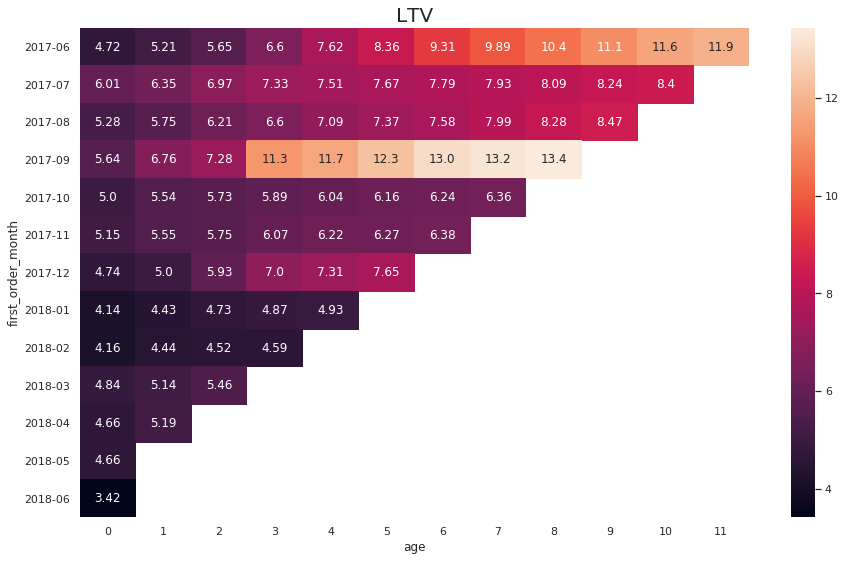

In [93]:
output.fillna('')
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV', fontsize=20)
sns.heatmap(output, annot=True, fmt='.3', linecolor='gray', yticklabels=output.index.strftime('%Y-%m'))
plt.show()

In [94]:
report['ltv'].mean().round(2)

1.15

Самая "доходная" когорта - сентябрьская, ее клиент в среднем приносит за 5 месяцев 11,7 у.е., - почти столько же вторая по доходности - июньская приносит за год. Остальные когорты сильно отстают от лидеров. Средняя валовая прибыль тоставила 1,15 у.е.

<a id="marketing"></a>
## 5 Маркетинг<a class="tocSkip">

<a id="marketing"></a>
- __Расходы на маркетинг: общие / на каждый источник / по времени__

Определим общие расходы на маркетинг.

In [95]:
print('Общие расходы на маркетинг:', costs['costs'].sum())

Общие расходы на маркетинг: 329131.62


Рассчитаем затраты по источникам.

In [96]:
costs.groupby('source_id').sum()

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


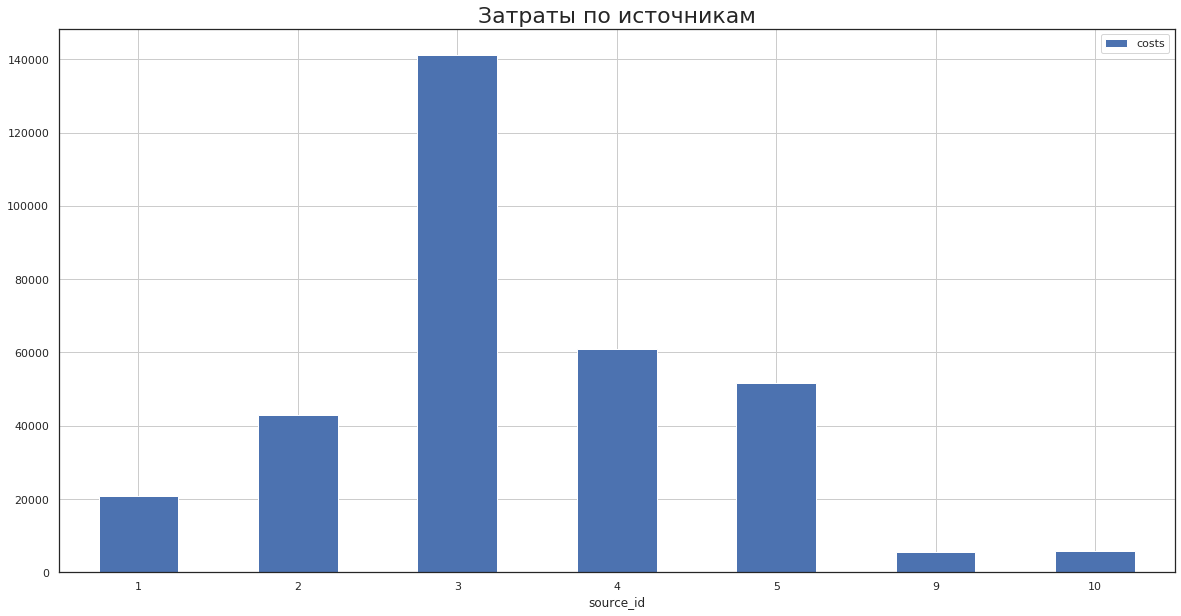

In [97]:
costs.groupby('source_id').sum().plot(kind='bar',figsize=(20, 10))
plt.title('Затраты по источникам', fontsize=22)
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

Самым дорогим источником является 3 - более 40% маркетинговых расходов, замыкают рейтинг 9 и 10 - менее 2%.

Найдем расходы по времени, в качестве периода возьмем месяц.

In [98]:
costs['month'] = costs['dt'].astype('datetime64[M]').dt.strftime('%Y-%m')

In [99]:
costs.groupby('month')['costs'].sum()

month
2017-06    18015.00
2017-07    18240.59
2017-08    14790.54
2017-09    24368.91
2017-10    36322.88
2017-11    37907.88
2017-12    38315.35
2018-01    33518.52
2018-02    32723.03
2018-03    30415.27
2018-04    22289.38
2018-05    22224.27
Name: costs, dtype: float64

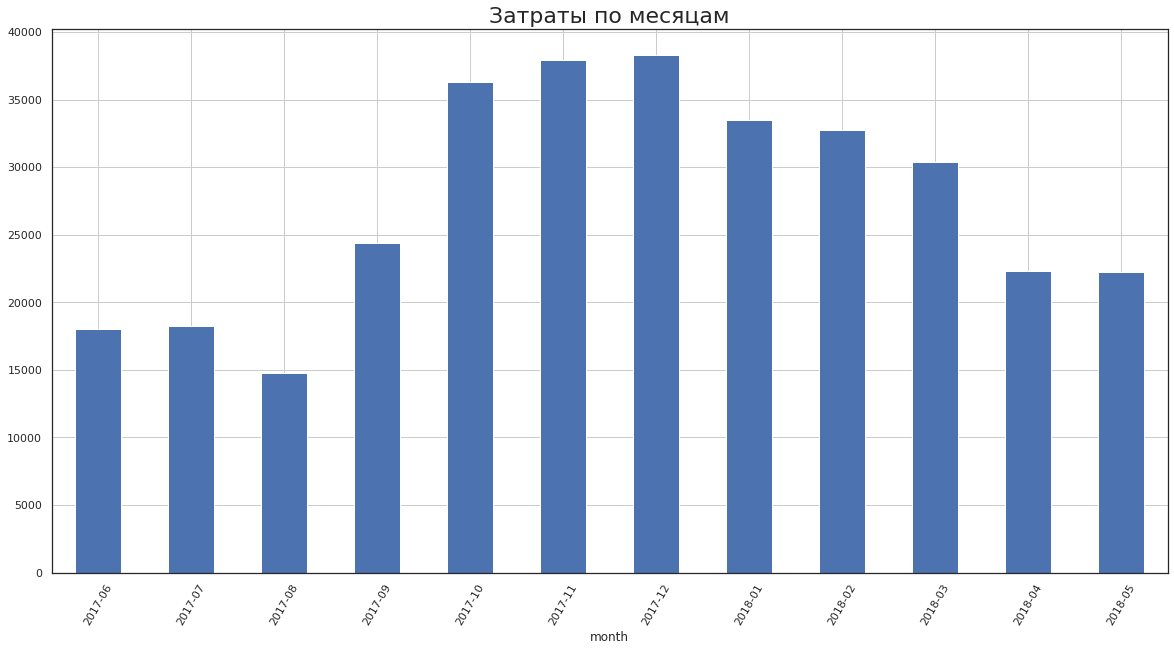

In [100]:
costs.groupby('month')['costs'].sum()\
.plot(kind='bar',figsize=(20, 10))
plt.title('Затраты по месяцам', fontsize=22)
plt.xticks(rotation=60)
plt.grid(True)
plt.show()

На данном графике мы можем увидеть, насколько распределение по времени затрат на маркетинг совпадает с продажами: те же минимальные значения летом, рост до декабря и снова спад к лету. Очевидно, уровень расходов на маркетинг и определяет уровень продаж.

Определим источники пользователей.

In [101]:
sources = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})

In [102]:
payers = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})

Рассчитаем LTV по источникам.

In [103]:
ltv = payers.merge(orders, on = 'uid')

In [104]:
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy']) / np.timedelta64(1,'M')).round().astype(int)

In [105]:
orders_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime',\
                                  values = 'revenue', aggfunc = 'count').fillna(0)

In [106]:
buyers_lifetime = ltv.pivot_table(index = 'source_id', columns = 'lifetime',\
                                  values = 'uid', aggfunc = 'nunique').fillna(0)

In [107]:
ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue',\
                      aggfunc = 'sum').fillna(0)

In [108]:
ltv = ltv.cumsum(axis = 1)

In [109]:
cohort_sizes = payers.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})

In [110]:
ltv = ltv.merge(cohort_sizes, on = 'source_id')

In [111]:
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size')

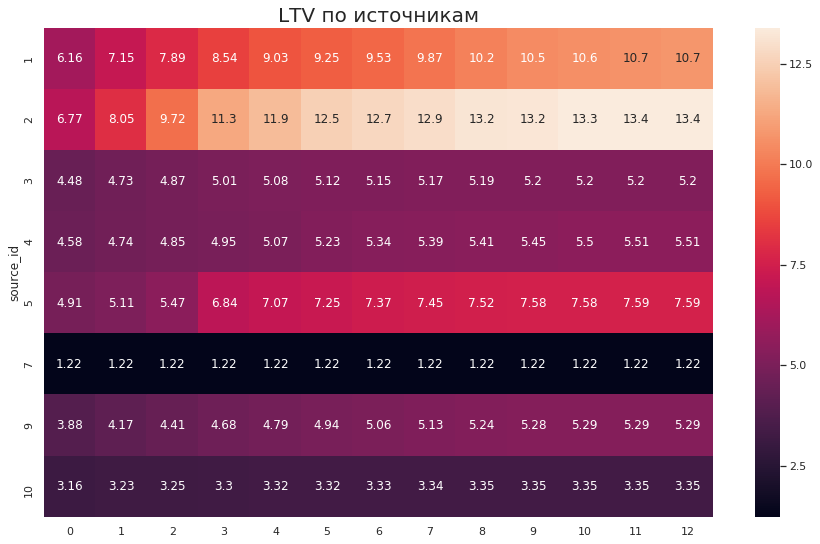

In [112]:
output.fillna('')
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV по источникам', fontsize=20)
sns.heatmap(ltv, annot=True, fmt='.3', linecolor='gray')
plt.show()

<a id="marketing2"></a>
- __Стоимость  привлечения одного покупателя из каждого источника CAC__

In [113]:
cac = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()\
.merge(cohort_sizes.reset_index(), left_on = 'source_id', right_on='source_id')

In [114]:
cac['cac'] = cac['costs'] / cac['cohort_size']

In [115]:
cac = cac.set_index('source_id')
display(cac)

,costs,cohort_size,cac
source_id,,,
1,20833.27,2899,7.186364
2,42806.04,3506,12.209367
3,141321.63,10473,13.493901
4,61073.60,10296,5.931779
5,51757.10,6931,7.467479
9,5517.49,1088,5.071222
10,5822.49,1329,4.381106


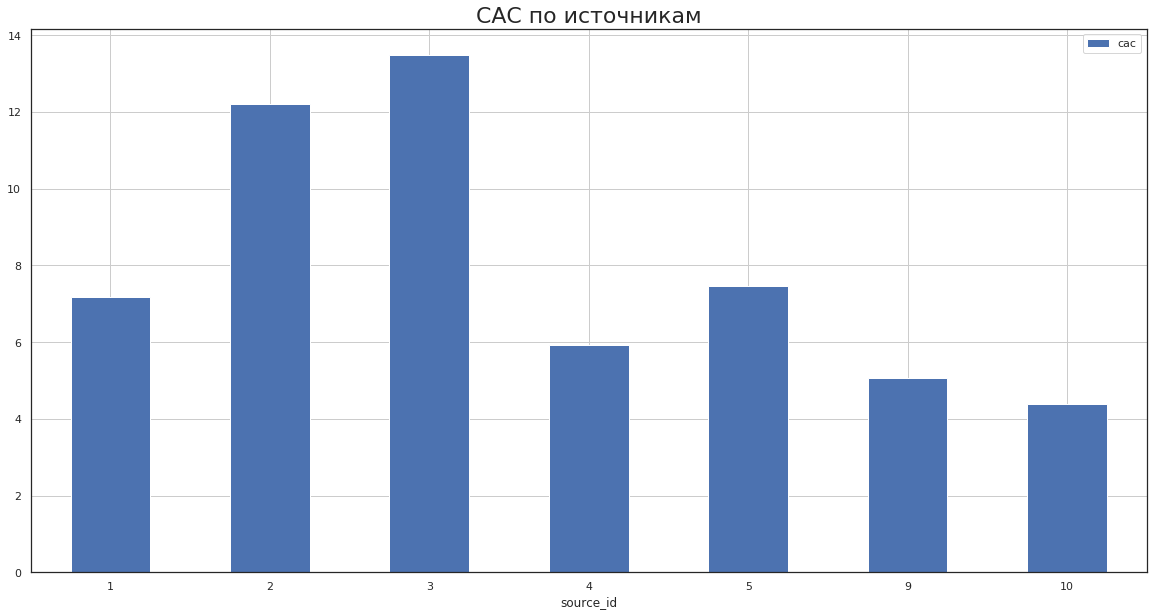

In [116]:
cac.plot(kind='bar',figsize=(20, 10), y="cac")
plt.title('САС по источникам', fontsize=22)
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

Самым дорогим является третий источник привлечения клиентов. Вероятно по пользователям из этого источника возникнут проблемы с окупаимостью.

<a id="marketing3"></a>
- __Окупаемость расходов - ROMI__

In [117]:
romi = ltv.merge(cac[['cac']], on = 'source_id')

In [118]:
romi = romi.div(romi['cac'], axis = 0).drop(columns = 'cac')

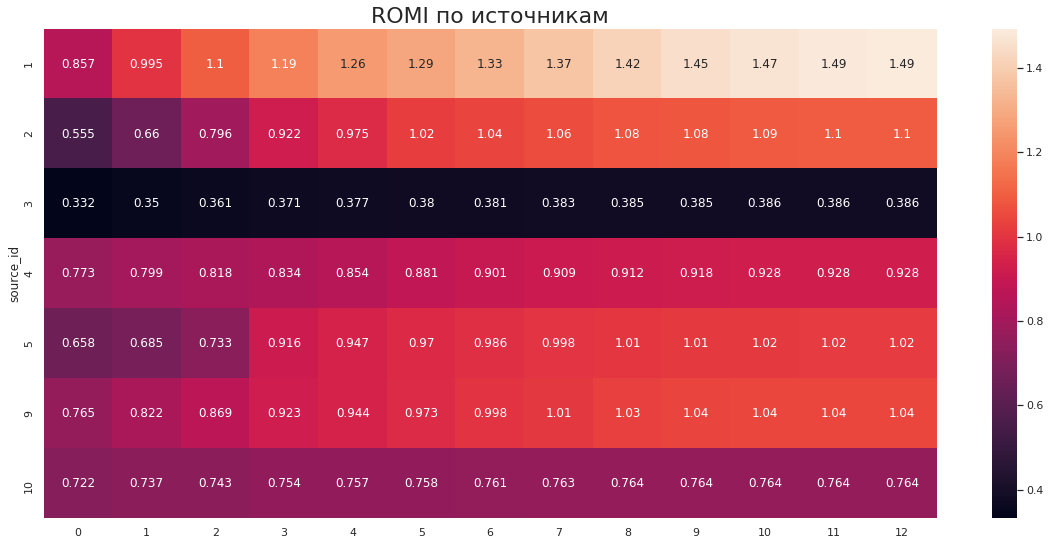

In [119]:
romi.fillna('')
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('ROMI по источникам', fontsize=22)
sns.heatmap(romi, annot=True, fmt='.3', linecolor='gray')
plt.show()

Лучшая окупаемость у перваго источника - прибыль уже через 2 месяца, кроме того в изучаемом периоде прибыль показали 2, 9 и 5 группы, 4 - близка, но еще не достигла точки окупаемости. А вот в 3-й - как мы и ожидали высокие расходы не окупаются.

<a id="close"></a>
## 6 Общий вывод<a class="tocSkip">

**На основании анализа исходных данных мы определили количество пользователей сервиса Яндекс.Афиша: в день -  907, в неделю - 5716, в месяц - 23228, средняя продолжительность сессии 10 мин, при этом чаще сего сессия длится 1 мин. У сервиса низкие показатели удержания клиента 8,5% - 7,9% - лучшие результаты в первых когортах,  последних же когортах даже в первый месяц возвращалось менее 5% пользователей.
 Чаще всего пользователь покупает спустя минуту после первого посещения сервиса. Наилучший месяц продаж - декабрь -канун Нового Года, худшие летние месяцы - сезон отпусков. Средний чек отличается не так заметно от месяца к месяцу, но и здесь самые дорогие в среднем покупки совершаются в декабре, а в январе и июне пользователи стараются экономить. Среднее значение за год 4.96 у.е. «Пожизненная» ценность клиента (LTV) по кагортам отличается незначительно, лучшая когорта - сентябрьская, ее клиент в среднем приносит за 5 месяцев 11,7 у.е. Средняя валовая прибыль от клиента составила 1,15 у.е.
 Общие расходы на маркетинг составили 329131.62 у.е., самым дорогим источником является 3 - более 40% маркетинговых расходов, замыкают рейтинг 9 и 10 - менее 2%. Разделив расходы по источникам привлечения пользователей мы можем сказать, что наиболшие затраты приходятся на источник 3 - 141321.63 у.е. (более 40%), наименьшие - 9 - 5517.49 у.е. и 10 - 5822.49 у.е., менее 2% каждый. Если сравнивать диаграммы маркетенговых затрат по месяцам с диаграммой продаж по месяцам можем предположить, что расходы намаркетинг определяет уровень продаж. Кроме того были рассчитаны «пожизненная» ценность клиента (LTV)  и окупаемость расходов (ROMI) по источникам, для визуализации были применены "тепловые карты". Рассчет LTV показал, что наиболшую "ценность клиента" приносят истчники 2 - 13,4 у.е. и 1 - 10,7 у.е. По результатам рассчета ROMI мы можем оценить срок окупаемости по исочникам, лучший результат у первого источника, худший у третьего - весьма средняя прибыль при высоких затратах. Таким образом можно рекомендовать пренести основную часть маркетинговхе расходов на источники 1, 2, 9 и 5, существенно уменьшив на 3.**